In [1]:
import pygor.load 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_path = 'C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/contralateral_OT_singleplane/st66/'


Found 6 custom classes in C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes
Class names: ['CenterSurround', 'Core', 'Experiment', 'FullField', 'MovingBars', 'STRF']
Access custom classes using 'from pygor.load import ClassName'


In [2]:
def flexible_reshape(array, columns):
    # Calculate the number of elements to keep
    elements_to_keep = (len(array) // columns) * columns
    # Reshape the array
    reshaped_array = array[:elements_to_keep].reshape(-1, columns)
    return reshaped_array

In [3]:
filename = '2024-8-27_x240827_1_1cOTs.h5'
stimtypes = ['stationary stripes','moving stripes','stationary stripes','OFF','dots_ON','OFF','ON','dots_OFF','ON', 'ON', 'loom']
stimtypes_relevant = ['moving stripes', 'dots_ON', 'dots_OFF', 'loom']
data_object = pygor.load.Core(data_path+filename)

C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:64: UserWarning: 'wDataCh0_detrended' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-27_x240827_1_1cOTs.h5, setting to np.nan
  self.images = try_fetch(HDF5_file, "wDataCh0_detrended")
C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:75: UserWarning: 'Positions' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-27_x240827_1_1cOTs.h5, setting to np.nan
  self.ipl_depths = try_fetch(HDF5_file, "Positions")
C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:77: UserWarning: 'Snippets0' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-27_x240827_1_1cOTs.h5, setting to np.nan
  self.snippets = try_fetch(HDF5_file, "Snippets0"

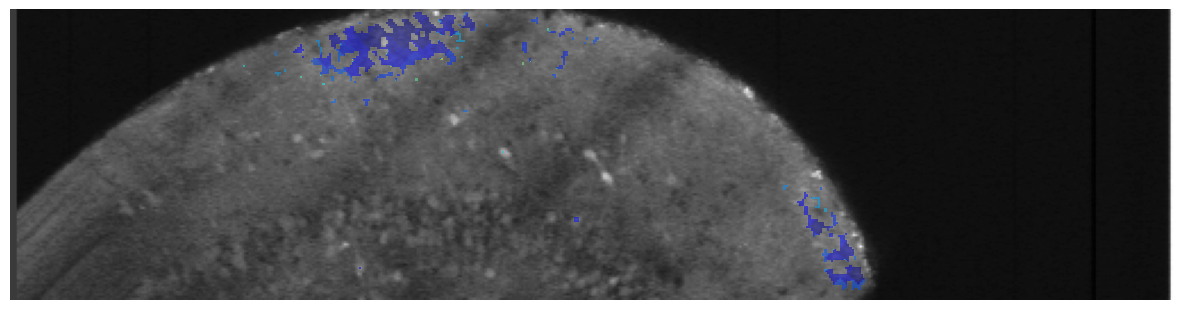

In [4]:
data_object.view_stack_rois(labels=False, figsize_scale=3, func='average_stack')

<b>Find where rois are located</b>

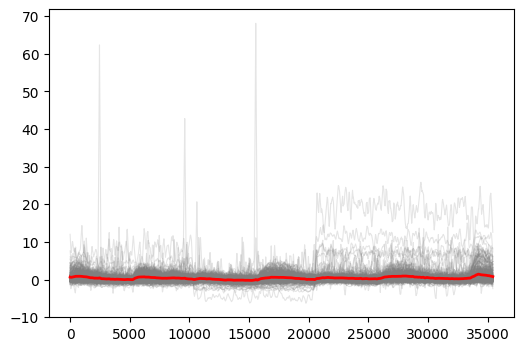

In [5]:


f1, ax1 = plt.subplots(1, 1, figsize=(6, 4))
#ax1.plot(data_object.averages.transpose(), color='grey', alpha=0.2, linewidth=0.5)
mean_roi_activity = np.mean(data_object.averages, axis=0)
plt.plot(data_object.averages.transpose(), color='grey', alpha=0.2, linewidth=0.8)
plt.plot(mean_roi_activity, color='red', alpha=1, linewidth=2)

traces = data_object.averages

In [6]:
triggertimes_ms = (data_object.triggerstimes_frame-data_object.triggerstimes_frame[0])/data_object.frame_hz/data_object.linedur_s

mean_triggertimes_ms = flexible_reshape(triggertimes_ms, data_object.trigger_mode)
mean_triggertimes_ms = np.mean(mean_triggertimes_ms, axis=0)-np.mean(mean_triggertimes_ms, axis=0)[0]
mean_triggertimes_extended = np.round(np.append(mean_triggertimes_ms, len(traces.transpose()))).astype(int)
print('Triggers at ms:', mean_triggertimes_ms)

Triggers at ms: [    0.          5120.00009138  7701.33347078 10218.66684904
 15317.33360671 17984.00032097 20544.00036666 25578.66712318
 28266.66717115 30784.00054941 32362.66724425]


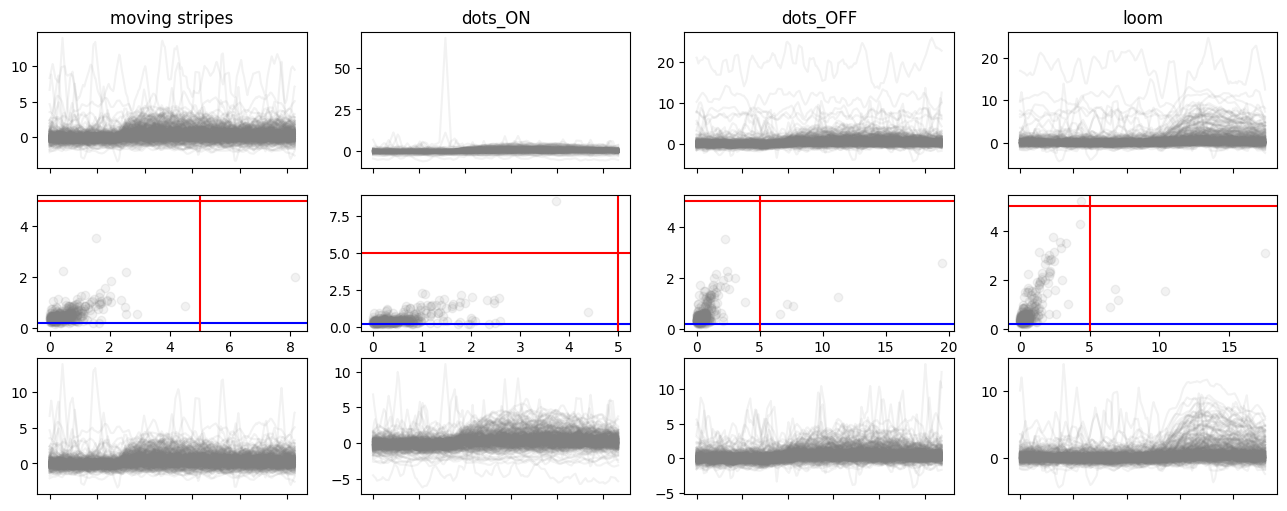

In [31]:
traces = data_object.averages

stim_responses = []

#find stimulus segments plus some time before and after
for idx, i in enumerate(mean_triggertimes_extended[:-1]):
    if stimtypes[idx] in stimtypes_relevant:
        append_idx = round(np.diff(mean_triggertimes_extended)[idx]/2)
        stim_responses.append(traces[:,i-append_idx:mean_triggertimes_extended[idx+1]+append_idx].transpose())  

#plot them
f, ax = plt.subplots(3, 4, figsize=(16, 6))
for idx, i in enumerate(stim_responses):
    ax[0, idx%4].plot(i, color='gray', alpha=0.1)  
    ax[0, idx%4].set_xticklabels([])
    ax[0, idx%4].set_title(stimtypes_relevant[idx])

#clean out non-responsive and jittery traces

std_lower = 0.2
std_upper = 5
mean_lower = -1
mean_upper = 5
for idx, cur_traces in enumerate(stim_responses):
    trace_means = abs(np.mean(cur_traces, axis=0))
    trace_stds = abs(np.std(cur_traces, axis=0))
    
    ax[1, idx%4].plot(trace_means, trace_stds, 'o', color='gray', alpha=0.1)
    ax[1, idx%4].axhline(y=std_upper, color='red')
    ax[1, idx%4].axhline(y=std_lower, color='blue')
    ax[1, idx%4].axvline(x=mean_upper, color='red')
    ax[2, idx%4].plot(cur_traces[:, np.where(
        (trace_stds<std_upper) & 
        (trace_stds>std_lower) & 
        (trace_means>mean_lower) & 
        (trace_means<mean_upper)) [0]], color='gray', alpha=0.1)  
    ax[2, idx%4].set_xticklabels([])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

#find out hwo many clusters we need for each response section

cluster_labels = []
#get the clusters for each response
for idx, i in enumerate(n_clusters_list):
    i_responses = stim_responses[idx]-np.mean(stim_responses[idx], axis=0)
    kmeans_data = cluster.KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans_data.fit(i_responses.transpose())
    cluster_labels.append(kmeans_data.labels_)

    
downsampled_cutouts = dots_off[:,::100]

cutout_means = abs(np.mean(dots_off, axis=1))
cutout_stds = abs(np.std(dots_off, axis=1))
cutouts_filtered = downsampled_cutouts[np.where((cutout_stds>0.0) & (cutout_stds>0.8))[0],:]


hdb = HDBSCAN(min_cluster_size=4)
clusters = hdb.fit_predict(cutouts_filtered)

ax3[0].set_title('hdbscan clustering')
for i, trace in enumerate(cutouts_filtered):
    if clusters[i] == -1:  # Noise points
        ax3[clusters[i]].plot(trace, color='gray', alpha=0.3)
    else:
        ax3[clusters[i]].plot(trace, color=plt.cm.rainbow(clusters[i] / np.max(clusters)), alpha=0.7)

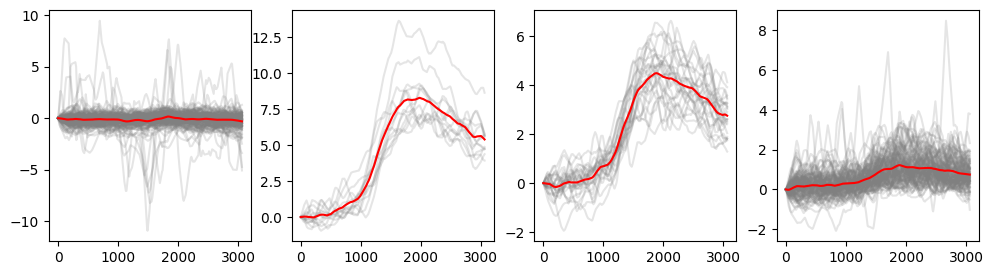

In [21]:
from sklearn import cluster

stim_clusters = []

dots_OFF = stim_responses[10]-stim_responses[10][1,:]
dots_off = dots_OFF.transpose()

kmeans_data = cluster.KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans_data.fit(dots_off)
labels = kmeans_data.labels_

f, ax = plt.subplots(1, 4, figsize=(12, 3))
for idx, i in enumerate(np.unique(labels)):
    ax[idx].plot(dots_off[labels==i,:].transpose(), color='gray', alpha=0.2)
    ax[idx].plot(np.mean(dots_off[labels==i,:].transpose(), axis=1), color='r')


[0.8145262  0.04359069 0.03485013 0.02711056 0.01625931]


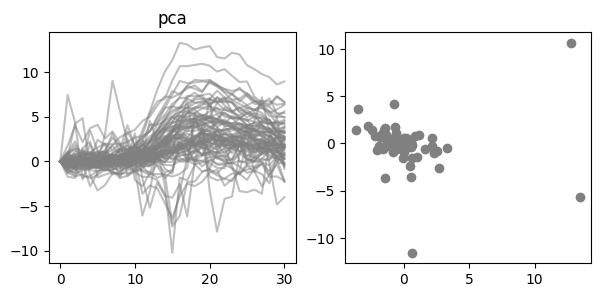

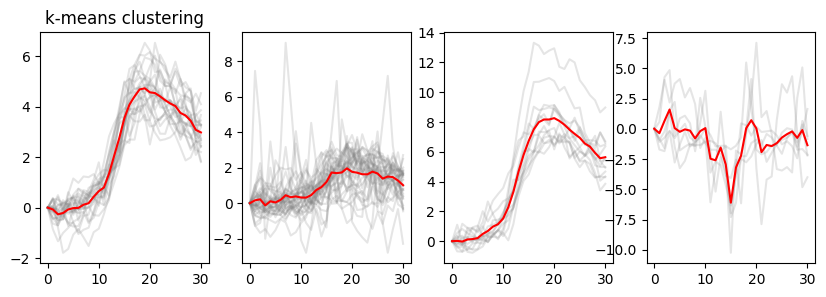

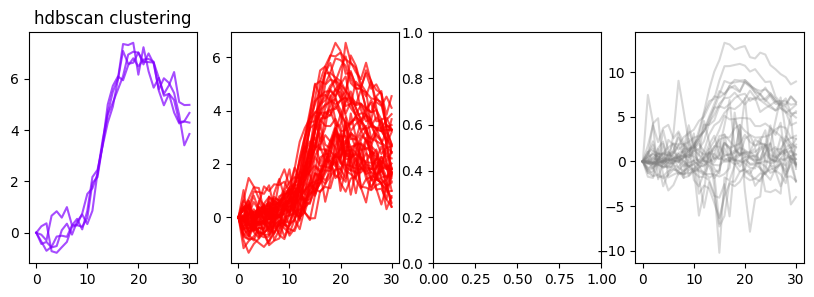

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

f, ax = plt.subplots(1,2, figsize=(7, 3))
f2, ax2 = plt.subplots(1,4, figsize=(10, 3))
f3, ax3 = plt.subplots(1,4, figsize=(10, 3))

downsampled_cutouts = dots_off[:,::100]

cutout_means = abs(np.mean(dots_off, axis=1))
cutout_stds = abs(np.std(dots_off, axis=1))
cutouts_filtered = downsampled_cutouts[np.where((cutout_stds>0.0) & (cutout_stds>0.8))[0],:]

ax[0].set_title('pca')
pca = PCA(n_components = 5)
principal_components = pca.fit_transform(cutouts_filtered)
ax[1].scatter(principal_components[:,1], principal_components[:,2], color='gray')
print(pca.explained_variance_ratio_)
ax[0].plot(cutouts_filtered.transpose(), color='grey', alpha=0.5)

kmeans_data = cluster.KMeans(n_clusters=4, init='k-means++', random_state=0)
kmeans_data.fit(cutouts_filtered)
labels = kmeans_data.labels_

ax2[0].set_title('k-means clustering')
for idx, i in enumerate(np.unique(labels)):
    ax2[idx].plot(cutouts_filtered[labels==i,:].transpose(), color='gray', alpha=0.2)
    ax2[idx].plot(np.mean(cutouts_filtered[labels==i,:].transpose(), axis=1), color='r')

hdb = HDBSCAN(min_cluster_size=4)
clusters = hdb.fit_predict(cutouts_filtered)

ax3[0].set_title('hdbscan clustering')
for i, trace in enumerate(cutouts_filtered):
    if clusters[i] == -1:  # Noise points
        ax3[clusters[i]].plot(trace, color='gray', alpha=0.3)
    else:
        ax3[clusters[i]].plot(trace, color=plt.cm.rainbow(clusters[i] / np.max(clusters)), alpha=0.7)


[0.34733152 0.22442001 0.10582747 0.05643829 0.04985859 0.04421137
 0.03011054 0.02828899 0.01502844 0.01271392]


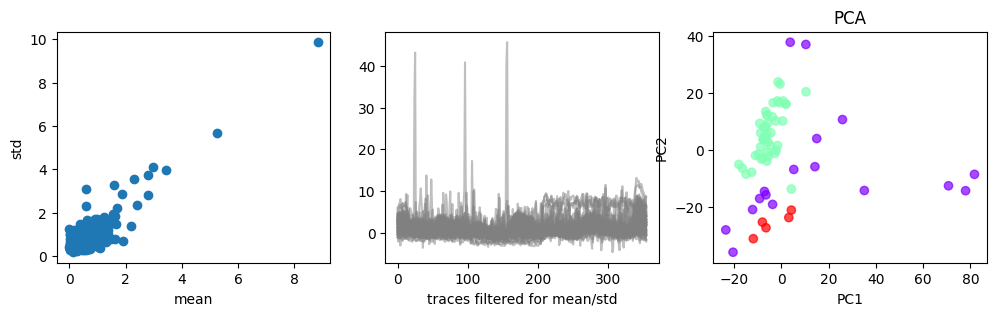

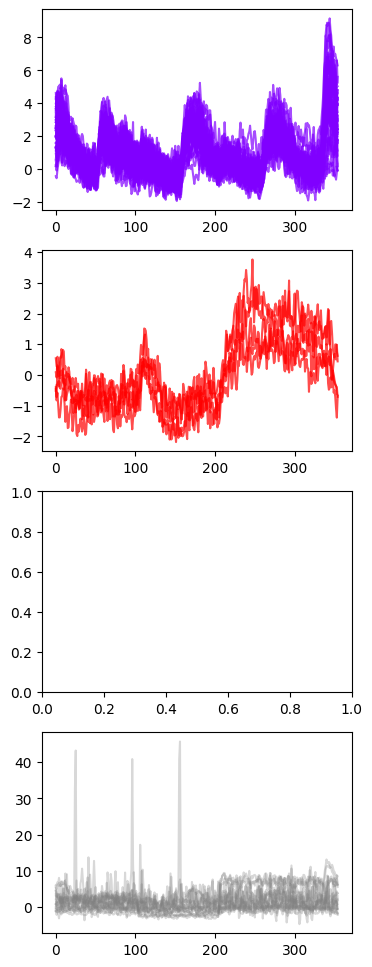

In [179]:
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
downsampled_traces = data_object.averages[:,::100]

lower_lim = 0.8
upper_lim = 5

f, ax = plt.subplots(1,3, figsize=(12,3))
trace_means = abs(np.mean(downsampled_traces, axis=1))
trace_stds = abs(np.std(downsampled_traces, axis=1))
downsampled_traces_filtered = downsampled_traces[np.where((trace_stds<5) & (trace_stds>0.8)) [0],:]
ax[0].plot(trace_means, trace_stds, 'o')
ax[0].set_xlabel('mean')
ax[0].set_ylabel('std')
ax[1].plot(downsampled_traces_filtered.transpose(), color='grey', alpha=0.5)
ax[1].set_xlabel('traces filtered for mean/std')

downsampled_traces_smoothed = 


pca = PCA(n_components = 10)
principal_components = pca.fit_transform(downsampled_traces_filtered)
#ax[2].scatter(principal_components[:,0], principal_components[:,1], color='gray')
ax[2].set_title('PCA')
ax[2].set_xlabel('PC1')
ax[2].set_ylabel('PC2')
print(pca.explained_variance_ratio_)

hdb = HDBSCAN(min_cluster_size=4)
clusters = hdb.fit_predict(downsampled_traces_filtered)
ax[2].scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='rainbow', alpha=0.7)

f2, ax2 = plt.subplots(4,1, figsize=(4, 12))
for i, trace in enumerate(downsampled_traces_filtered):
    if clusters[i] == -1:  # Noise points
        ax2[clusters[i]].plot(trace, color='gray', alpha=0.3)
    else:
        ax2[clusters[i]].plot(trace, color=plt.cm.rainbow(clusters[i] / np.max(clusters)), alpha=0.7)

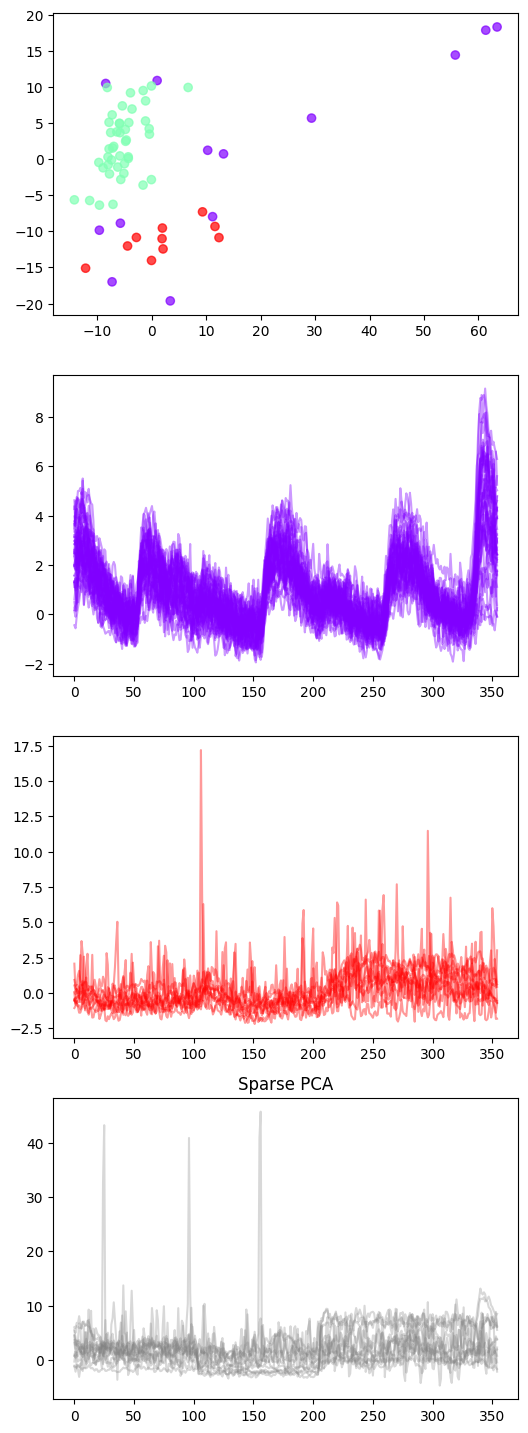

In [162]:
from sklearn.decomposition import SparsePCA

f, ax = plt.subplots(4,1, figsize=(6,18))
sparse_pca = SparsePCA(n_components = 8, alpha=1.5, n_jobs=-1)
sparse_principal_components = sparse_pca.fit_transform(downsampled_traces_filtered)
#ax[0].scatter(sparse_principal_components[:,0], sparse_principal_components[:,1], color='green')
plt.title('Sparse PCA')

hdb = HDBSCAN(min_cluster_size=4)
clusters = hdb.fit_predict(sparse_principal_components)
ax[0].scatter(sparse_principal_components[:, 0], sparse_principal_components[:, 1], c=clusters, cmap='rainbow', alpha=0.7)

for i, trace in enumerate(downsampled_traces_filtered):
    if clusters[i] == -1:  # Noise points
        ax[clusters[i]].plot(trace, color='gray', alpha=0.3)
    else:
        ax[clusters[i]+1].plot(trace, color=plt.cm.rainbow(clusters[i] / np.max(clusters)), alpha=0.4)

Plot rois by cluster allocation

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_12268\3224778297.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_12268\3224778297.py:31: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram(linkage(euc_distances, method="complete"), ax=ax, color_threshold=125)
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_12268\3224778297.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_12268\3224778297.py:37: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage(euc_distances, method="complete"), criterion="distance", t=125
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_12268\3224778297.py:45: RuntimeWarning: 

10


C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_12268\3224778297.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


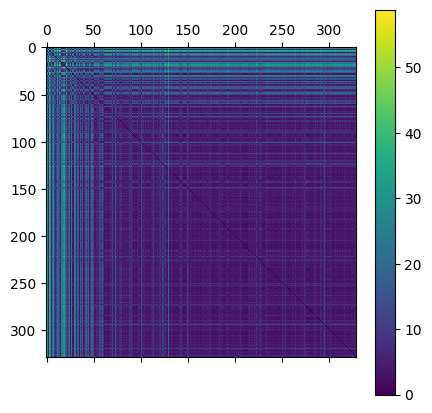

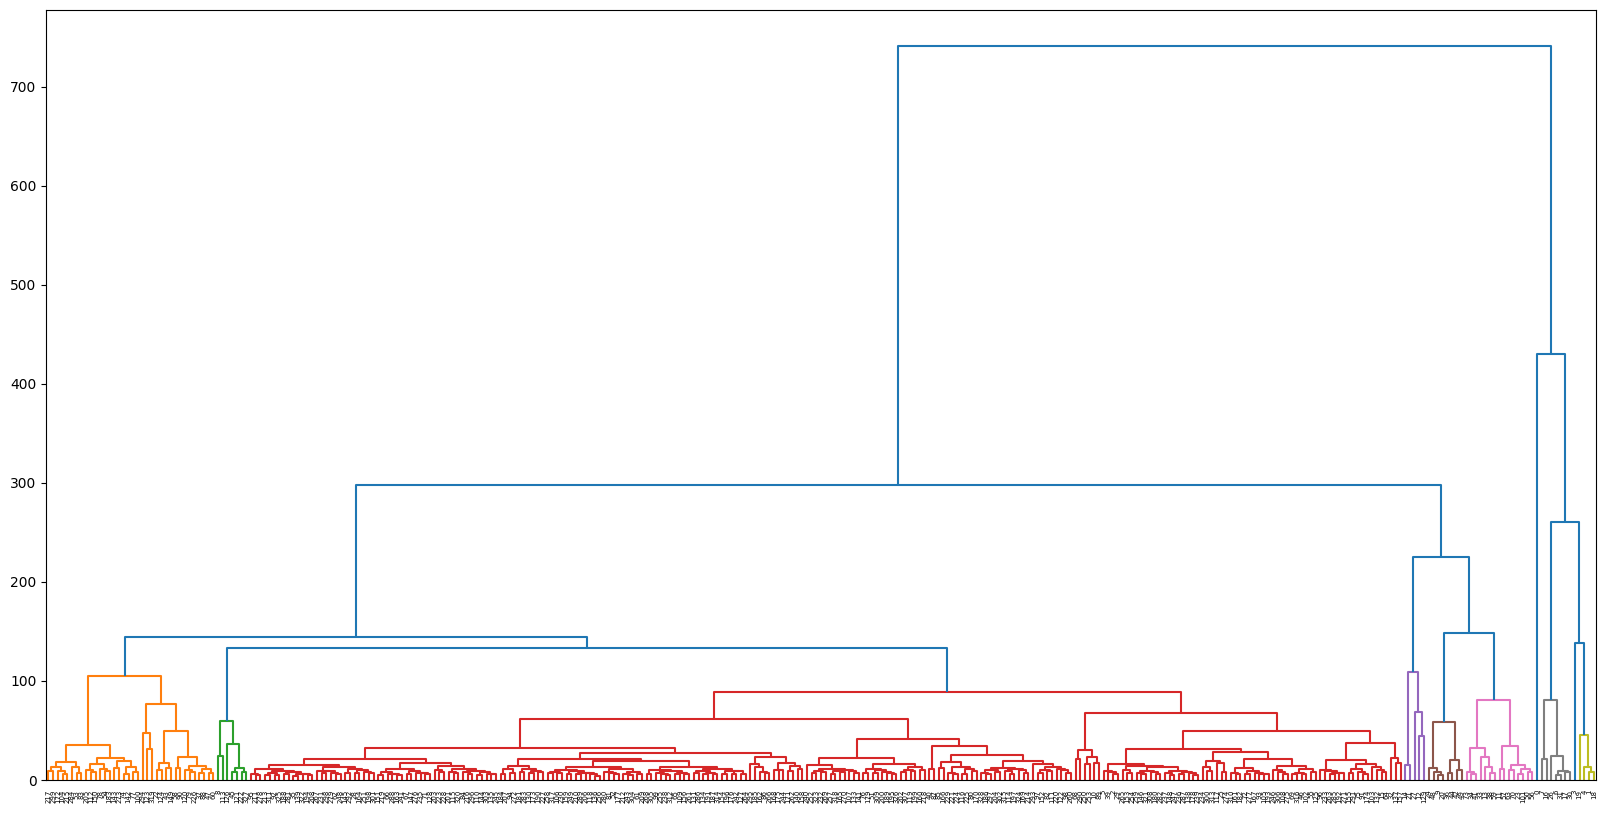

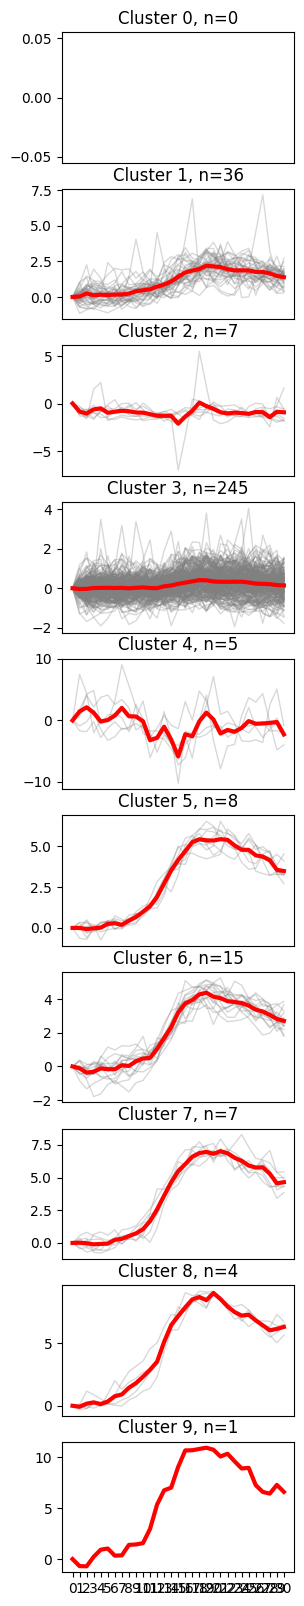

In [59]:
import numpy as np
from sklearn.metrics import euclidean_distances, pairwise_distances
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# %% Load data
data = downsampled_cutouts

# %% Euclidean distance matrix
euc_distances = euclidean_distances(data)
# or more general
distances = pairwise_distances(data, metric="euclidean", n_jobs=-1)
# You can also use dynamic time warping to create the distance matrix
# from tslearn.metrics import dtw
# distances = np.zeros((data.shape[0], data.shape[0]))
# for i in range(data.shape[0]):
#     for j in range(data.shape[0]):
#         distances[i, j] = dtw(data[i], data[j])

# %% Visualize distance matrix
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cax = ax.matshow(euc_distances)
fig.colorbar(cax)
fig.show()
# ax.set_xlim(100, 150)
# ax.set_ylim(100, 150)

# %% plot dendrogram with indicated threshold
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
dendrogram(linkage(euc_distances, method="complete"), ax=ax, color_threshold=125)
fig.show()

# %% Cluster data based on distance matrix

clustering = fcluster(
    linkage(euc_distances, method="complete"), criterion="distance", t=125
)
print(np.max(clustering))

# %% Plot clusters
fig, ax = plt.subplots(np.max(clustering), 1, figsize=(3, 20))
for i in range(np.max(clustering)):
    ax[i].plot(data[clustering == i].transpose(), color='grey', alpha=0.3, linewidth=1)
    ax[i].plot(np.nanmean(data[clustering == i], axis=0), color='red', linewidth=3)
    ax[i].set_xticks([])
    ax[i].set_title(f"Cluster {i}, n={np.sum(clustering == i)}")
ax[-1].set_xticks(range(data.shape[1]))
fig.show()

Calculate how many clusters are suitable for k-means

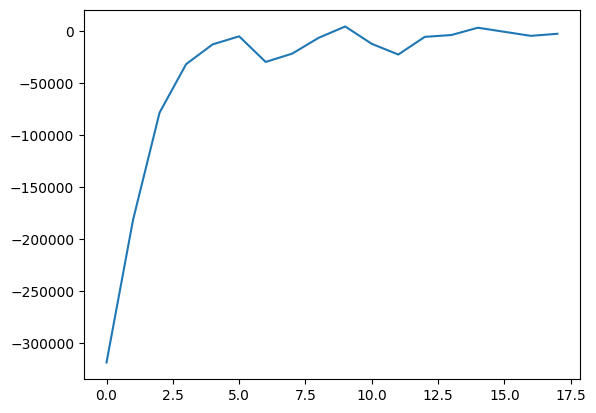

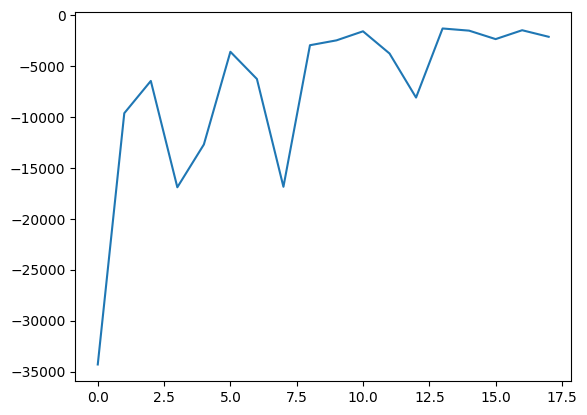

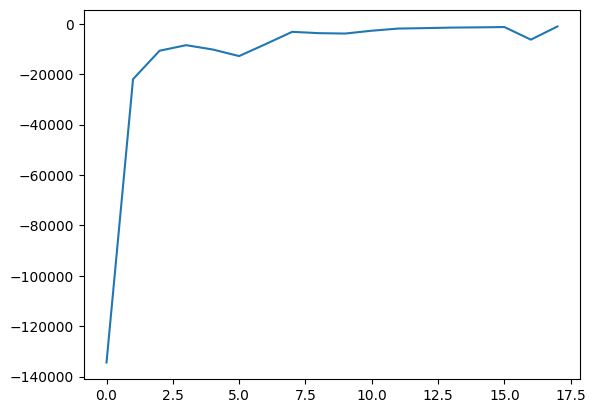

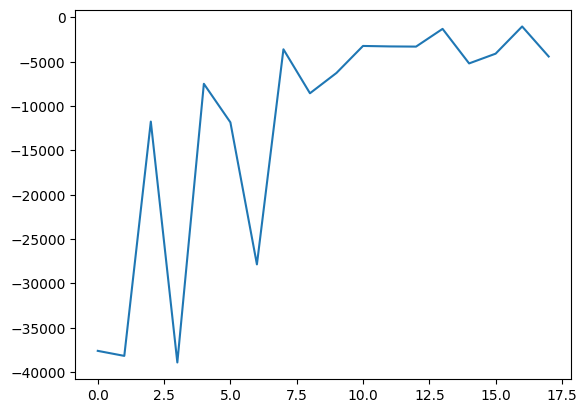

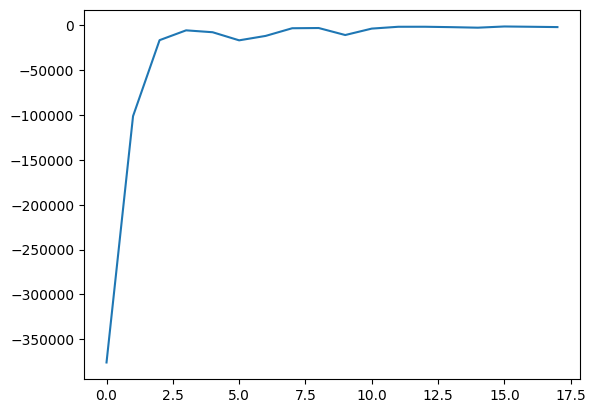

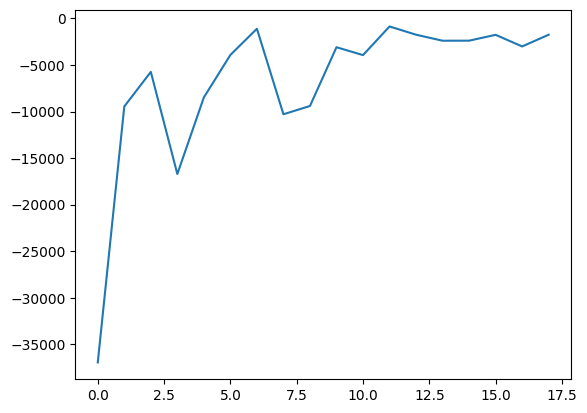

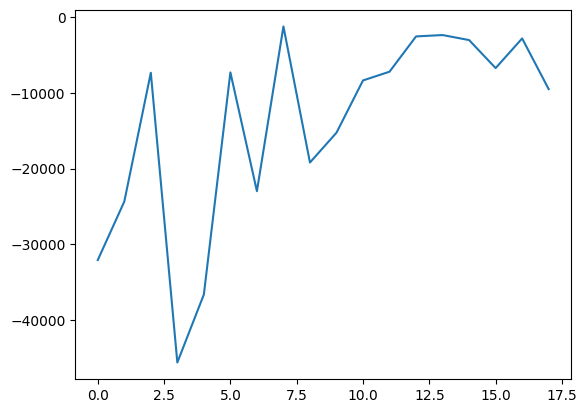

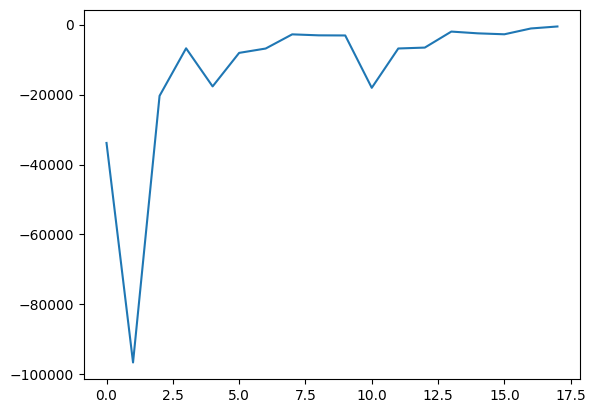

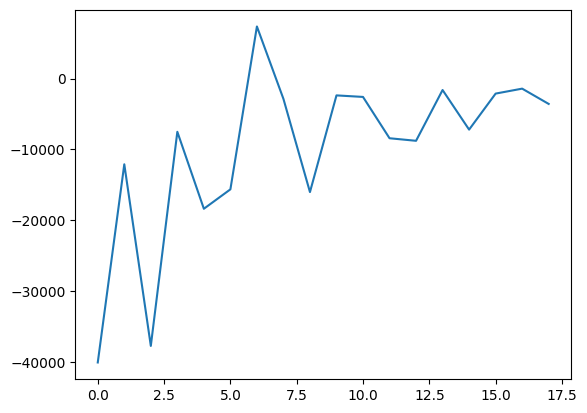

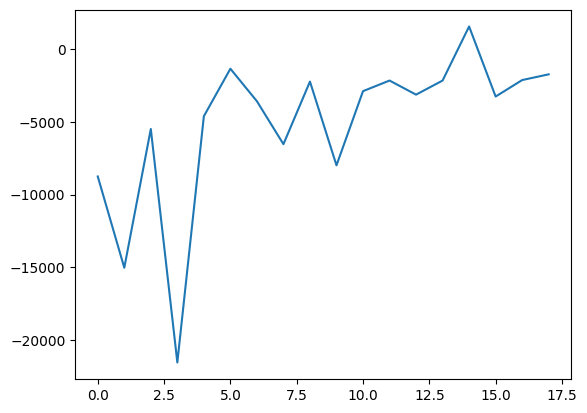

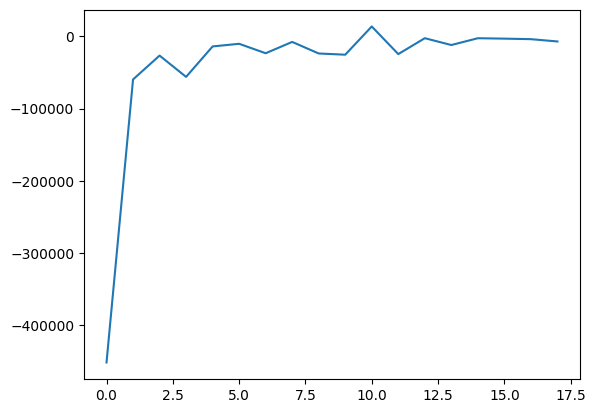

In [32]:
n_clusters_list = []

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def find_percent_drop(x, a, b, c, target_value):
    return exp_decay(x, a, b, c) - target_value

#find out hwo many clusters we need for each response section
for iter_responses in stim_responses:
    i_responses = iter_responses-np.mean(iter_responses, axis=0)
    cost = []
    n_clust = 20
    for i in range(1, n_clust):
        kmeans_data = cluster.KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans_data.fit(i_responses.transpose())
        cost.append(kmeans_data.inertia_)
    f, ax = plt.subplots()
    ax.plot((np.diff(cost)))

    # x = np.arange(0, len(cost))
    
    # initial_guess = [500000, 2, 100000]

    # popt, pcov = curve_fit(exp_decay, x, cost, p0=initial_guess, maxfev=2000)
    # a, b, c = popt
    # x_fit = np.linspace(min(x), max(x), 100)
    # y_fit = exp_decay(x_fit, *popt)
    # #ax.plot(x_fit, y_fit, label=f"Fitted function: y = {a:.2f} * exp(-{b:.2f} * x) + {c:.2f}", color='red')

    # initial_value = a+c  # y at x = 0
    
    # target_value = c + 0.1 * (initial_value-c) 
    # print(initial_value, target_value)
    # x_percent_drop = fsolve(find_percent_drop, x0=1, args=(a, b, c, target_value))[0]
    # plt.axvline(x_percent_drop)

    n_clusters = len(np.where(abs(np.diff(np.diff(cost)))/abs(np.diff(np.diff(cost)))[-1]>5)[0])
    n_clusters_list.append(round(x_percent_drop))

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_1616\142156462.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv')(np.linspace(0, 1, 11))
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_1616\142156462.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  clustcolors = plt.cm.get_cmap('hsv')(np.linspace(0, 1, 20))


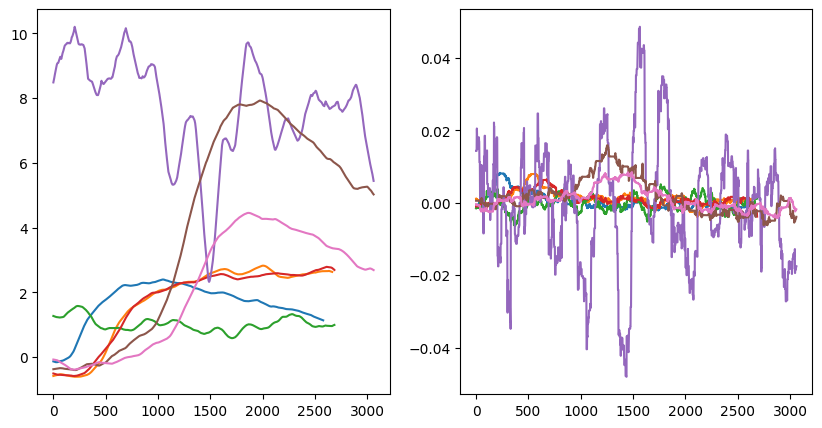

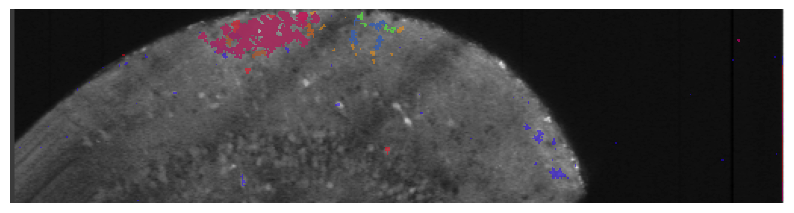

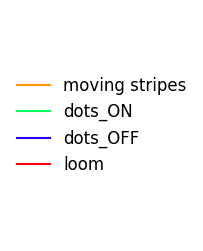

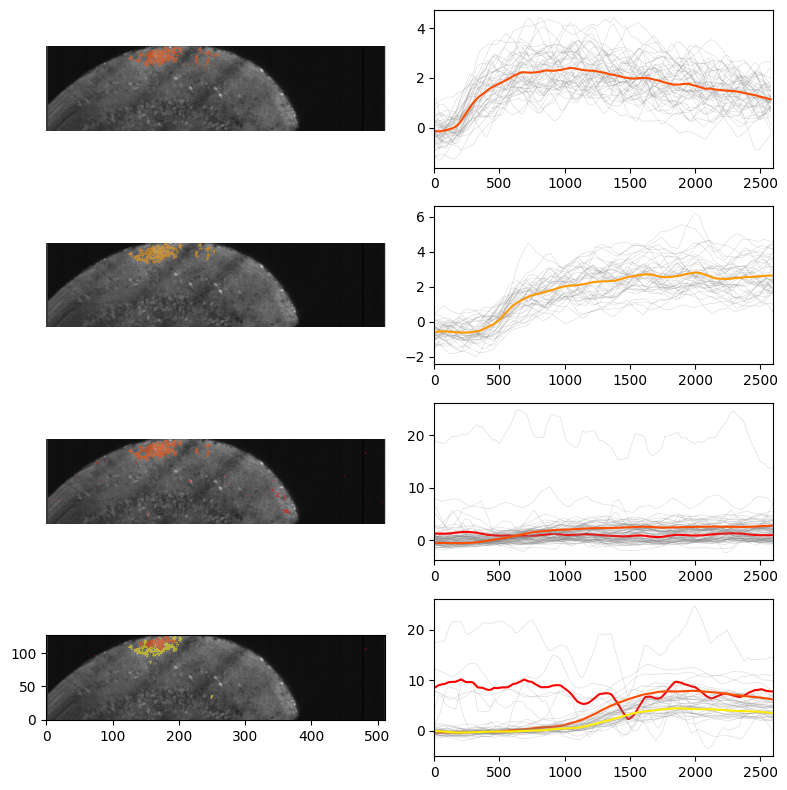

In [34]:
min_traces_per_cluster = 2
clust_thresh = 0.005

stimuli_to_plot = ['moving stripes', 'dots_ON', 'dots_OFF', 'loom']
#stimuli_to_plot = ['stationary stripes','moving stripes','stationary stripes','OFF','dots_ON','OFF','ON','dots_OFF','ON',]
#stimuli_to_plot = ['dots_OFF']
n_traces = np.zeros(len(stimuli_to_plot))
colors = plt.cm.get_cmap('hsv')(np.linspace(0, 1, 11))
clustcolors = plt.cm.get_cmap('hsv')(np.linspace(0, 1, 20))
f, ax = plt.subplots(1, 2, figsize=(10, 5))
f2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
f3, ax3 = plt.subplots(1, 1, figsize=(1.5, 3))
f4, ax4 = plt.subplots(len(stimuli_to_plot), 2, figsize=(8,8))

for background_image in range(len(stimuli_to_plot)):
    ax4[background_image, 0].imshow(data_object.average_stack, cmap="Greys_r", origin="lower")

handles_labels = {}
ax2.imshow(data_object.average_stack, cmap="Greys_r", origin="lower")
stim_responsive_clusters = []
for idx_stim, cur_label_array in enumerate(cluster_labels):
    for idx_label, cur_label in enumerate(np.unique(cur_label_array)):
        cur_cluster_mean = np.mean(stim_responses[idx_stim][:, cur_label_array == cur_label], axis=1)
        if idx_stim > -1:
            if np.shape(stim_responses[idx_stim][:, cur_label_array == cur_label])[1] >= min_traces_per_cluster:
                if np.max(np.diff(cur_cluster_mean) > clust_thresh):
                    if stimtypes[idx_stim] in stimuli_to_plot:    
                        found_rois = (np.where(cur_label_array == cur_label)[0] + 1) * -1
                        mask = np.isin(data, found_rois)

                        # Plot cluster means and differences
                        ax[0].plot(cur_cluster_mean)
                        ax[1].plot(np.diff(cur_cluster_mean))

                        # Create a colored overlay where only the mask part is colored
                        color = colors[idx_stim]  # Select the color for the current idx_stim
                        clustcolor=clustcolors[cur_label]
                        colored_mask = np.zeros((*mask.shape, 4))  # Create an RGBA image (shape + 4 for RGBA)
                        clust_mask = np.zeros((*mask.shape, 4))
                        if idx_stim not in handles_labels:
                            ax3.plot(0, 0, color=color, label=stimtypes[idx_stim])
                            handles_labels[idx_stim] = f'Stim {idx_stim}'  # Track the label
                        
                        # Apply color only to the ROI parts of the mask
                        colored_mask[mask] = np.array([*color[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5
                        clust_mask[mask] = np.array([*clustcolor[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5

                        # Plot the colored mask over the background
                        ax2.imshow(colored_mask, interpolation='none', origin="lower")
                        try:
                            index_of_dots_ON = stimuli_to_plot.index(stimtypes[idx_stim])
                            ax4[index_of_dots_ON, 0].imshow(clust_mask, interpolation='none', origin="lower")
                            ax4[index_of_dots_ON, 1].plot(stim_responses[idx_stim][:, cur_label_array == cur_label], color='grey', alpha=0.3, linewidth=0.4)
                            ax4[index_of_dots_ON, 1].plot(cur_cluster_mean, color=clustcolor, linewidth=1.5)
                            #ax4[index_of_dots_ON, 1].set_ylim([-6, 15])
                            ax4[index_of_dots_ON, 1].set_xlim([0, 2600])
                            n_traces[index_of_dots_ON] = n_traces[index_of_dots_ON] + len(stim_responses[idx_stim][:, cur_label_array == cur_label].transpose())
                        except:
                            print('stim not in list')
                        
ax2.axis('off')
ax3.axis('off')
ax4[0,0].axis('off')
#ax4[0,1].axis('off')
ax4[1,0].axis('off')
#ax4[1,1].axis('off')
ax4[2,0].axis('off')
#ax4[2,1].axis('off')
f4.tight_layout()
# Make the legend take up the whole figure
ax3.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=12, ncol=1, frameon=False)

f4.savefig('roiclusters.svg')



In [35]:
n_traces

array([47., 41., 88., 45.])

Try other clustering methods: self-organizing maps (SOM)

In [36]:
# # Algorithms
# from minisom import MiniSom
# import pickle

# def plot_som_series_averaged_center(som_x, som_y, win_map):
#     fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
#     fig.suptitle('Clusters')
#     for x in range(som_x):
#         for y in range(som_y):
#             cluster = (x,y)
#             if cluster in win_map.keys():
#                 for series in win_map[cluster]:
#                     axs[cluster].plot(series,c="gray",alpha=0.5) 
#                 axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
#             cluster_number = x*som_y+y+1
#             axs[cluster].set_title(f"Cluster {cluster_number}")


# def get_som_series_averaged_center(som_x, som_y, win_map):
#     clustered_traces = []
#     cluster_averages = []
#     for x in range(som_x):
#         for y in range(som_y):
#             cluster = (x,y)
#             if cluster in win_map.keys():
#                 clustered_traces.append(np.vstack(win_map[cluster]))
#                 cluster_averages.append(np.average(np.vstack(win_map[cluster]),axis=0))
#     return clustered_traces, cluster_averages

# som_x = som_y = 3 #math.ceil(math.sqrt(math.sqrt(len(traces))))
# traces = dots_OFF.transpose()
# som = MiniSom(som_x, som_y,len(traces[0]), sigma=0.5, learning_rate = 0.2, neighborhood_function='mexican_hat', random_seed=10)
# som.random_weights_init(traces)
# som.train(traces, 50000)

# #save the SOM
# with open('C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/clustering analysis/mexicamhat_sigma1.5_randomseed10_lr0.1', 'wb') as outfile:
#     pickle.dump(som, outfile)

# win_map = som.win_map(traces)

# plot_som_series_averaged_center(som_x, som_y, win_map)

# clustered_traces, cluster_averages = get_som_series_averaged_center(som_x, som_y, win_map)

# f, ax = plt.subplots(len(cluster_averages), 1, figsize=(7, 30))
# for i in range(len(cluster_averages)):
#     ax[i].plot(clustered_traces[i], color='r')
#     ax[i].plot(cluster_averages[i], color='r')
#     ax[i].set_xticklabels([])
#     ax[i].set_yticklabels([])
#     ax[i].set_xlim(0, len(cluster_averages[i]))
#     ax[i].spines['top'].set_visible(False)
#     ax[i].spines['right'].set_visible(False)
#     ax[i].spines['bottom'].set_visible(False)
#     ax[i].spines['left'].set_visible(False)

# ax.tight_layout()
